In [1]:
import numpy as np
import commpy as cp
from commpy.channelcoding import Trellis
from commpy.modulation import QAMModem

import utils as utils
from signal_generator import SignalGenerator
from baseline_receiver import BaselineReceiver
from modular_receiver import ModularReceiver

# Visualization
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()  # Use seaborn as backend of matplotlib for vis

## Define Paramters for the comparison

In [5]:
# For encoding/decoding convolutional codes
G = np.array([[0o7, 0o5]]) 
M = np.array([2])
trellis = Trellis(M, G, feedback=0o7, code_type='rsc')

class Params:
    SNR_RANGE = range(-5, 30, 5)
    NUM_SAMPLES = 100
    BLOCK_LENGTH = 100
    BPSK, QPSK, QAM16, QAM64 = 2, 4, 16, 64
    
modem = QAMModem(m=Params.QPSK)
signal_generator = SignalGenerator(modem=modem)

## Define Baseline (Demod + Viterbi) & Modular Receivers (NN + RNN)

In [6]:
baseline_receiver = BaselineReceiver(modem, trellis)
modular_receiver = ModularReceiver(
    demod_model_path='./models/demod_model_qpsk.hdf5',
    decoder_model_path='./models/BiGRU.hdf5')

## Evaluate Baseline  on multiple SNRs

* For each SNR, generate (orignal message bits, modulated signals, noisy signals) using `SignalGenerator`.
* Run demodulation of baseline and modular version (a NN).
* Run decoder of baseline (viterbi) and modular version (a RNN).
* Log and results and plot

100%|██████████| 7/7 [00:19<00:00,  2.73s/it]


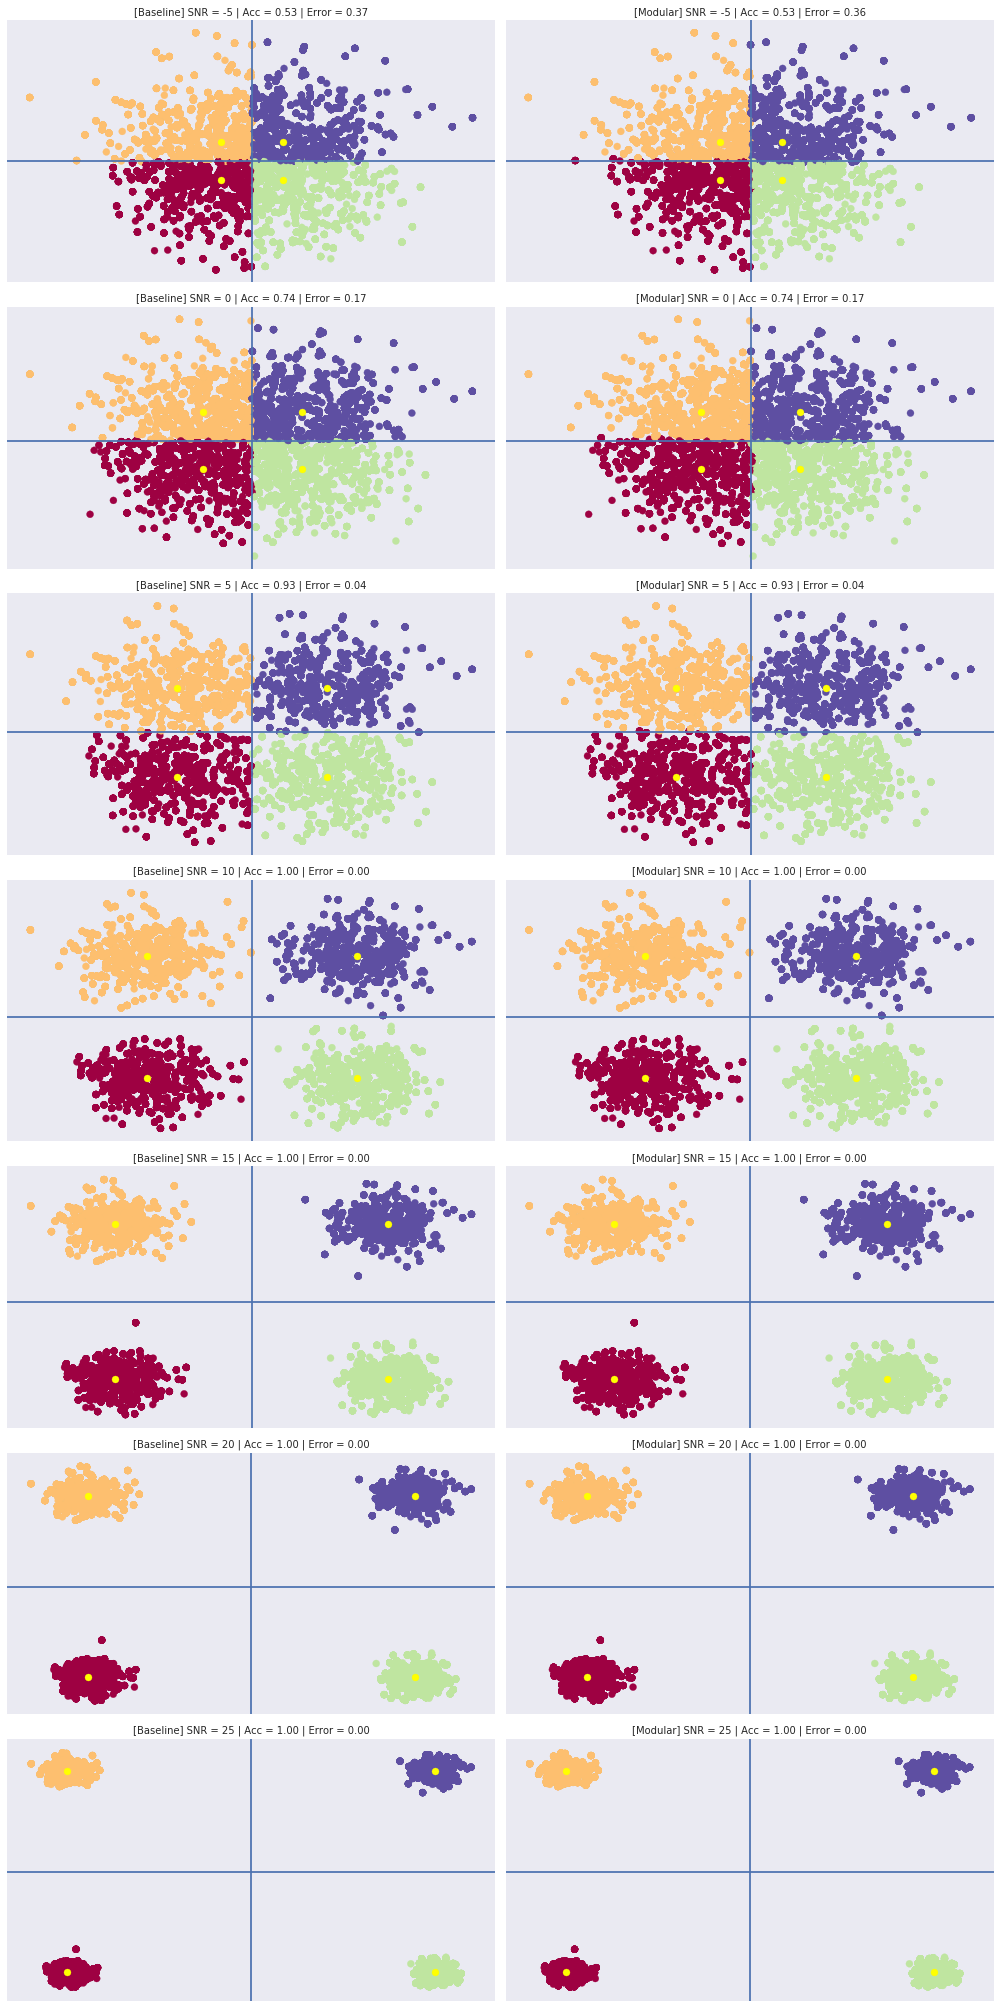

In [7]:
import tqdm

errors_logs = []
accuracies_logs = []
ber_logs  = []
bler_logs = []

fig, axes = plt.subplots(len(Params.SNR_RANGE), 2, figsize=(14, 4 * len(Params.SNR_RANGE)))
for i, snr in tqdm.tqdm(enumerate(Params.SNR_RANGE), total=len(Params.SNR_RANGE)):
    (original_bits, clean_signals, noisy_signals) = signal_generator(
        Params.NUM_SAMPLES, 
        Params.BLOCK_LENGTH, 
        snr_in_dB=snr)
    
    complex_inputs = noisy_signals.flatten()
    mapping, ground_truths = np.unique(clean_signals.flatten(), return_inverse=True)

    # ####################################
    # Run Baseline/Neral Demodulation
    # ####################################
    baseline_predictions = baseline_receiver.demodulate(complex_inputs)
    nn_predictions       = modular_receiver.demodulate(complex_inputs)

    # ####################################
    # Run Baseline/Neral Decoder
    # ####################################
    
    # Convert Symbols to Complex Number, then to real numbers.
    baseline_demoded = modem.demodulate(mapping[baseline_predictions].flatten(), 'hard')
    nn_demoded       = modem.demodulate(mapping[nn_predictions].flatten(), 'hard')
    
    # Preprocess input to feed into RNN
    nn_demoded = nn_demoded.reshape((Params.NUM_SAMPLES, -1))
    nn_demoded = nn_demoded[:, : 2 * Params.BLOCK_LENGTH].reshape((-1, Params.BLOCK_LENGTH, 2))
    
    # Estimate original bits using baseline (viterbi) and nn decoder
    baseline_estimated = baseline_receiver.decode(baseline_demoded) # Viterbi
    
    # @TODO: fix BUGGGGGGG :(
    nn_estimated       = modular_receiver.decode(nn_demoded)        # Bi-directional GRU
    
    nn_estimated = np.where(nn_estimated > 0.5, 1, 0).astype(np.int)
    baseline_estimated = baseline_estimated.reshape((Params.NUM_SAMPLES, -1))[:, :Params.BLOCK_LENGTH]
    
    # ####################################
    # Measure Accuracy / error
    # #################################### 
    # For demod
    acc, err       = utils.get_scores(baseline_predictions, ground_truths)    
    nn_acc, nn_err = utils.get_scores(nn_predictions, ground_truths)
    
    # For decoder
    ber, bler        = utils.get_ber_bler(baseline_estimated, original_bits)
    nn_ber, nn_bler = utils.get_ber_bler(nn_estimated, original_bits)
    
    ber_logs.append([ber, nn_ber])
    bler_logs.append([bler, nn_bler])
    errors_logs.append([err, nn_err])
    accuracies_logs.append([acc, nn_acc])
    
    # ####################################
    # Visualize Modulation
    # ####################################
    data_point_limit = 10000
    title    = '[Baseline] SNR = {} | Acc = {:.2f} | Error = {:.2f}'.format(snr, acc, err)
    nn_title = '[Modular] SNR = {} | Acc = {:.2f} | Error = {:.2f}'.format(snr, nn_acc, nn_err)

    utils.visualize_demodulation(complex_inputs[:data_point_limit], modem.constellation, ax=axes[i, 0],
        predictions=baseline_predictions[:data_point_limit],
        title=title)
    utils.visualize_demodulation(complex_inputs[:data_point_limit], modem.constellation, ax=axes[i, 1],
        predictions=nn_predictions[:data_point_limit],
        title=nn_title)

fig.tight_layout()

### Compare Demodulation Performance (Error / Accuracy)

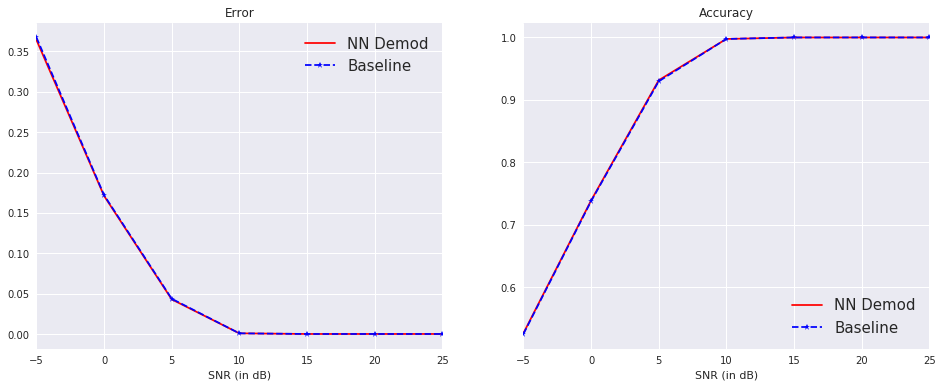

In [8]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
utils.visualize_acc_err(ax1, ax2, errors_logs, accuracies_logs, Params.SNR_RANGE)

### Compare Decoder Performance (error / accuracy)

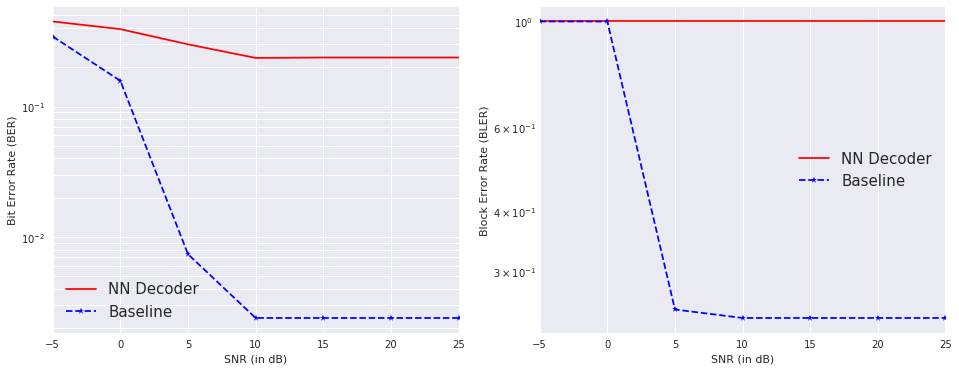

In [9]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
utils.visualize_ber_bler(ax1, ax2, ber_logs, bler_logs, Params.SNR_RANGE)

_ =ax1.semilogy()
_ = ax2.semilogy()

In [13]:
nn_demoded[0:1].shape

(1, 100, 2)

In [14]:
test = modular_receiver.rnn_model.predict(nn_demoded[0:1])

In [20]:
print(np.squeeze(test, -1).round())

[[0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
  1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1.
  0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
  1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
  1. 0. 0. 1.]]


In [18]:
print(original_bits[0])

[0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 1.]
